In [1]:
import numpy as np 
import matplotlib.pyplot as plt
plt.gray();

<Figure size 432x288 with 0 Axes>

In [2]:
### Still need to figure out a set of realistic parameters

sz=512
mpix=4e-8 ### pixel to meter
wavelen=2e-12/mpix ### wave length

ix=(np.arange(sz, dtype=float)-sz/2)*1e-3 ## indices along x direction. need to be much smaller than y
ix_mat=(ix-ix[:,None])**2

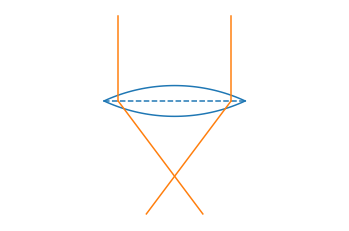

In [3]:
### First try a simple example
### focus a parallel beam with a lens

def draw_lens(arc, w=1):
    t=np.arange(-np.pi*arc, np.pi*arc+1e-5, np.pi*arc/20.)+(np.pi/2.)
    x=np.cos(t)
    y=np.sin(t)
    y-=np.min(y)
    x/=np.max(x)-np.min(x)
    x*=w
    plt.plot(x,y, 'C0')
    plt.plot(x,-y, 'C0')
    plt.plot([np.min(x), np.max(x)],[0,0],'--')

draw_lens(.15)
plt.plot([-.4,-.4],[0,.6], 'C1')
plt.plot([.4,.4],[0,.6], 'C1')
plt.plot([.4,-.2],[0,-.8], 'C1')
plt.plot([-.4,.2],[0,-.8], 'C1')
plt.axis("equal")
plt.axis('off');

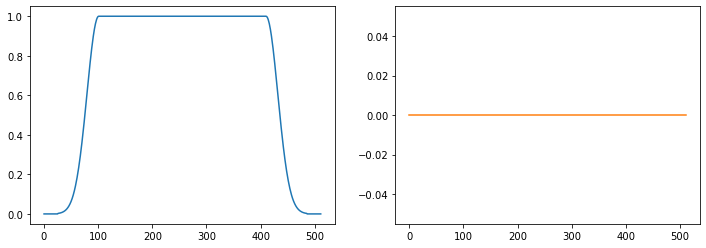

In [4]:
### Parallel beam input. Need Gaussian falloff to avoid edge artifacts
### plots are in amplitude / phase format

def gauss_edge(sz, cl=.2, gw=.15, gs=.06):
    raw=np.ones(sz, dtype=np.complex)
    clip=int(sz*cl)
    gwidth=int(sz*gw)
    gwidth=min(clip-1, gwidth)
    gsig=sz*gs
    raw[:clip]=0
    raw[-clip:]=0
    gaus=np.exp((-np.arange(gwidth, dtype=float)**2)/(gsig**2))
    raw[clip-gwidth:clip]=gaus[::-1]
    raw[-clip:-clip+gwidth]=gaus
    return raw

img0=gauss_edge(sz)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(abs(img0),'C0')
plt.subplot(1,2,2)
plt.plot(np.angle(img0),'C1')

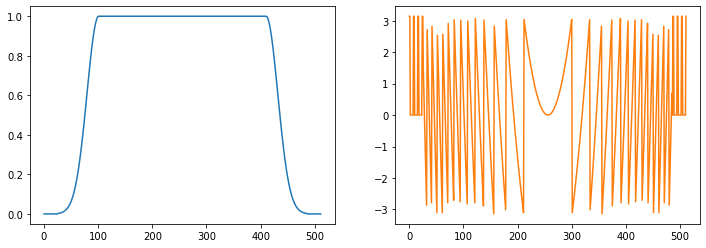

In [5]:
### Propagate the wave through a thin lens
### radial based phase shift

def wave_lens(raw, f, cs, doplot=True):
    
    ps=((ix)**2)/(f*2)*(2*np.pi/wavelen) ### phase shift
    ps+=cs*(ix**4)/4.
    img=raw*np.exp(-1j*(-ps)) 

    if doplot:
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.plot(abs(img),'C0')
        plt.subplot(1,2,2)
        plt.plot(np.angle(img),'C1')
    return img

img1=wave_lens(img0, 40, 0)

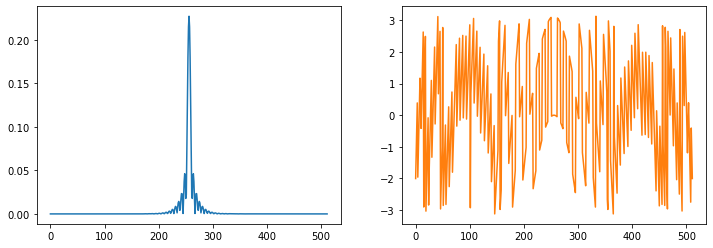

In [6]:
### Propagate wave through space
### should shrink to a point at focal plane

def wave_prop(raw, d0, doplot=True):
    dst=np.sqrt(ix_mat +d0**2) 
    cpx=raw[:,None]*np.exp(-1j*2*np.pi*dst/wavelen)*(1/dst**2)
    img=np.sum(cpx, axis=0)

    if doplot:
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.plot(abs(img),'C0')
        plt.subplot(1,2,2)
        plt.plot(np.angle(img),'C1')
    return img

img2=wave_prop(img1, 40)

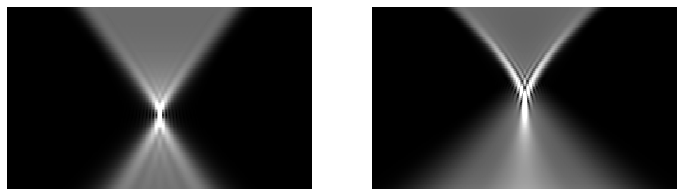

In [7]:
### How Cs of the lens affect the focus

plt.figure(figsize=(12,6))
for ii,cs in enumerate([0,3e4]):
    plt.subplot(1,2,ii+1)
    img1=wave_lens(img0, 40, cs, False)

    imgs=[]
    rg=np.arange(10,61,.5)
    for i in rg:
        imgs.append(wave_prop(img1, i, False))

    imgs=np.array(imgs)
    m=abs(imgs)
    m/=np.std(m, axis=1)[:,None]
    m=np.repeat(m,3,0)
    plt.imshow(m, vmax=5)
    plt.axis('off')
    

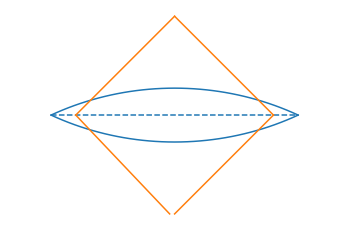

In [8]:
### Now a slightly more complicated example
### Image thin sample under focus

d0=20.
d1=20.
f=1./(1/d0+1/d1)

draw_lens(.15)
plt.plot([-.4,0],[0,.4], 'C1')
plt.plot([.4,0],[0,.4], 'C1')
plt.plot([.4,.0],[0,-.4], 'C1')
plt.plot([-.4,-.02],[0,-.4], 'C1')
plt.axis("equal")
plt.axis('off');

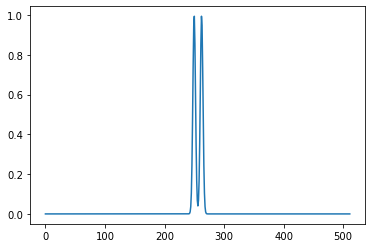

In [9]:
### Sample density input

ni=2

sample=np.zeros(sz)
dx=25/ni

nx=np.arange(ni)*dx
nx=nx-np.mean(nx)+sz//2
for x in nx:
    sample+=np.exp(-(np.arange(sz, dtype=float)-x)**2/10)
    
plt.plot(sample)

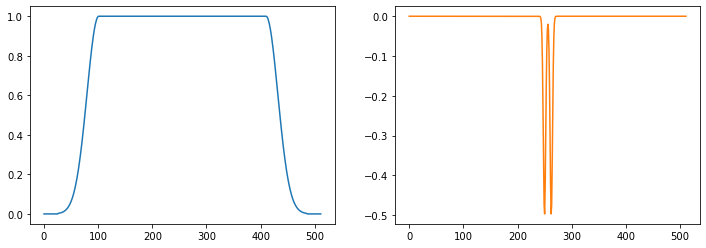

In [10]:
### Elastic scattering only cause phase shift at output beam

img0=gauss_edge(sz)
img0*=np.exp(-1j*sample*.5)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(abs(img0),'C0')
plt.subplot(1,2,2)
plt.plot(np.angle(img0),'C1')


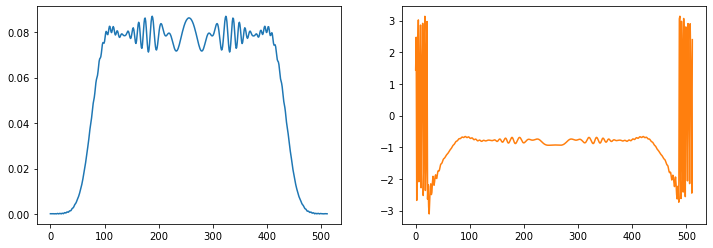

In [11]:
### Propagate wave to the lens

img1=wave_prop(img0, d0)

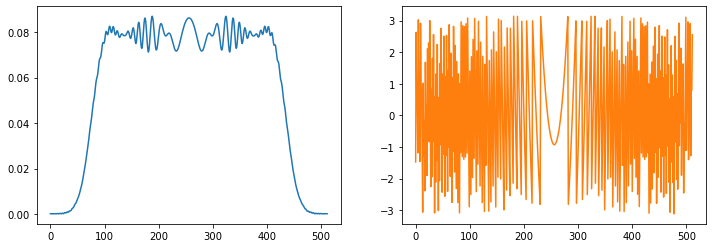

In [12]:
### Go through the lens

img2=wave_lens(img1, f, 0)

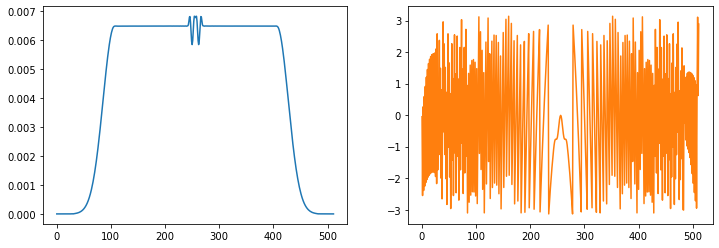

In [13]:
### Get to the imaging plane

df=-.3
img3=wave_prop(img2, d1+df)

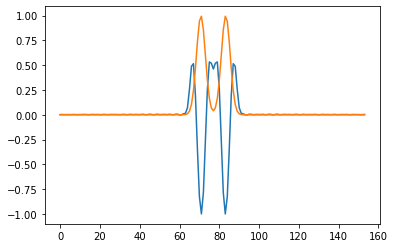

In [14]:
### Now compare the sample input and the output image

m=abs(img3) # we only observe real space image on camera
m=m[::-1]  # image is flipped along x axis
c=int(sz*.3) # remove the background
m[:c]=m[c]
m[-c:]=m[-c]
c=int(sz*.35)
m=m[c-1:-c-1]
m-=np.mean(m)
m/=np.max(abs(m))
s=sample.copy()
s=s[c:-c]


plt.plot(m)
plt.plot(s)


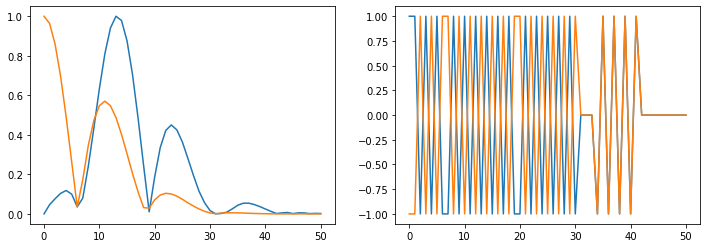

In [15]:
### Compare in Fourier space

nn=(sz-c*2)//3
rft=np.fft.rfft(s)
rft/=np.max(abs(rft))


mft=np.fft.rfft(m)
mft/=np.max(abs(mft))


### Note that the signal is near zero at some frequency
### need to set the corresponding phase to zero for comparison

mx=abs(mft)
msk=np.ones(len(mx), dtype=bool)
msk[1:-1]*=mx[1:-1]<mx[:-2]
msk[1:-1]*=mx[1:-1]<mx[2:]


am=np.cos(np.angle(mft))
ar=np.cos(np.angle(rft))
am[mx<.01]=0
ar[mx<.01]=0
for i in np.where(msk>0)[0][:-1]:
    ar[i]=ar[i+1]
    am[i]=am[i+1]


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(abs(mft)[:nn])
plt.plot(abs(rft)[:nn])
plt.subplot(1,2,2)

plt.plot(am[:nn])
plt.plot(ar[:nn])


-1.9


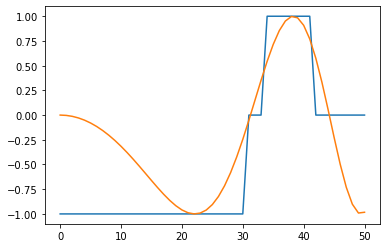

In [16]:
### Compare the phase difference from simulation and the ideal CTF curve

k2=(np.arange(0,len(rft))/len(rft)*sz/2)**2

ci=df*3-1 ### not sure why this is needed yet. the number are fitted from the last cell
ctf=np.sin(ci*np.pi*wavelen*k2)
plt.plot(np.sign((ar*am)[:nn]))
plt.plot(ctf[:nn])
# plt.plot(np.sign(ctf[:nn])*.5)
print(ci)

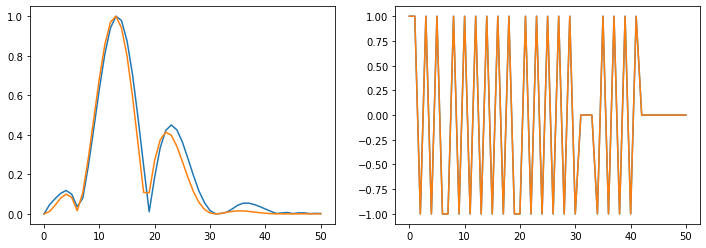

In [17]:
### Apply the ideal CTF curve to the input signal and compare with the simulation output

rc=rft*ctf
rc/=np.max(abs(rc))
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(abs(mft)[:nn])
plt.plot(abs(rc)[:nn])
plt.subplot(1,2,2)
ac=np.cos(np.angle(rc))
ac[mx<.01]=0
for i in np.where(msk>0)[0][:-1]:
    ac[i]=ac[i+1]

plt.plot(ac[:nn])
plt.plot(am[:nn])

-2.989600437876299 1.0507991242473995


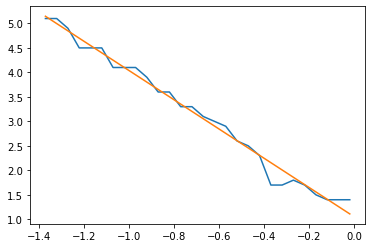

In [18]:
### This is used to fit the defocus scale factor between the simulation and ideal CTF curve
### Should be able to directly compute it from the parameters of the simulation...

rrg=-np.arange(.02,1.4,.05)

cis=[]
for df in rrg:
    img3=wave_prop(img2, d1+df, False)
    m=abs(img3)
    m=m[::-1]
    c=int(sz*.3)
    m[:c]=m[c]
    m[-c:]=m[-c]
    c=int(sz*.375)
    m=m[c-1:-c-1]
    m-=np.mean(m)
    m/=np.max(abs(m))
    s=sample.copy()
    s=s[c:-c]

    nn=(sz-c*2)//3
    rft=np.fft.rfft(s)
    rft/=np.max(abs(rft))


    mft=np.fft.rfft(m)
    mft/=np.max(abs(mft))

    mx=abs(mft)
    msk=np.ones(len(mx), dtype=bool)
    msk[1:-1]*=mx[1:-1]<mx[:-2]
    msk[1:-1]*=mx[1:-1]<mx[2:]


    am=np.cos(np.angle(mft))
    ar=np.cos(np.angle(rft))
    am[mx<.01]=0
    ar[mx<.01]=0
    for i in np.where(msk>0)[0][:-1]:
        ar[i]=ar[i+1]
        am[i]=am[i+1]

    k2=(np.arange(0,len(rft))/len(rft)*sz/2)**2
    sn=np.sign((ar*am))[:nn]
    c0=[]
    rr=np.arange(0,20,.1)
    for i in rr:
        ctf=np.sin(-i*np.pi*wavelen*k2)
        ctf=np.sign(ctf[:nn])
        c0.append(np.mean(ctf*sn))

    ci=np.argmax(c0)
    cis.append(rr[ci])
    
cis=np.array(cis)
k,b=np.polyfit(rrg, cis, 1)
print(k,b)
plt.plot(rrg, cis)
plt.plot(rrg, rrg*k+b)